In [1]:
import numpy as np
import gplearn
import sklearn.datasets as load_data
from gplearn.genetic import SymbolicRegressor
from gplearn.genetic import SymbolicTransformer
from gplearn.functions import make_function
from gplearn.fitness import make_fitness
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.preprocessing import StandardScaler

# First a regression example

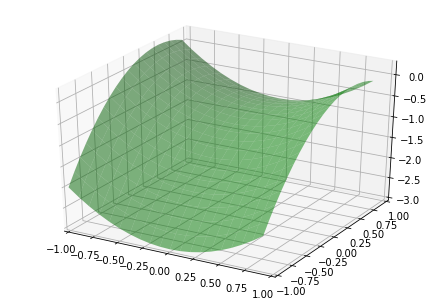

In [2]:
x0 = np.arange(-1, 1, 1 / 10.0)
x1 = np.arange(-1, 1, 1 / 10.0)
x0, x1 = np.meshgrid(x0, x1)

y_truth = x0 ** 2 - x1 ** 2 + x1 - 1

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride = 1, cstride = 1,  color = "green", alpha = 0.5)
plt.show()




In [3]:
np.random.seed(42)
X_train = np.random.uniform(-1, +1, 100).reshape([50, 2])
y_train = X_train[:, 0] ** 2  - X_train[:, 1] ** 2 + X_train[:, 1] - 1

X_test = np.random.uniform(-1, +1, 100).reshape([50, 2])
y_test = X_test[:, 0] ** 2  - X_test[:, 1] ** 2 + X_test[:, 1] - 1


In [4]:
est_gp = SymbolicRegressor(population_size=5000, generations=20,
                          stopping_criteria = 0.01, p_crossover = 0.7,
                          p_subtree_mutation = 0.1, p_hoist_mutation = 0.05,
                          p_point_mutation = 0.1, max_samples=0.9, verbose = 1,
                          parsimony_coefficient = 0.001, random_state = 0)

In [5]:
est_gp.fit(X_train, y_train)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13 833681.4804527623        7 0.2734448568356541 0.4315929924209402     58.12s
   1    13.98 5.01116569818506        9 0.2682489497899117 0.5473565928567637      1.62m
   2    11.35 15.693295393707482       19 0.2131760759354283 0.4002487488135542      1.63m
   3     6.63 13.531108051972284       11 0.22237987851450136 0.4036859714317648      1.52m
   4     5.94 1.1409238062385418       19 0.20786839265244564 0.4480178983603979      1.40m
   5      7.6 1.161294021218703       19 0.1672104299522976 0.13313084091301616      1.34m
   6    11.47 1.3379755284056705       19 0.16494587937005745 0.1535117961531774      1.32m
   7    13.39 1.1910161492228852       19 0.14615264001387665 0.32265095035880476      1.29m
   8    13.49 0.802335864

SymbolicRegressor(const_range=(-1.0, 1.0),
         function_set=('add', 'sub', 'mul', 'div'), generations=20,
         init_depth=(2, 6), init_method='half and half', max_samples=0.9,
         metric='mean absolute error', n_jobs=1, p_crossover=0.7,
         p_hoist_mutation=0.05, p_point_mutation=0.1, p_point_replace=0.05,
         p_subtree_mutation=0.1, parsimony_coefficient=0.001,
         population_size=5000, random_state=0, stopping_criteria=0.01,
         tournament_size=20, verbose=1, warm_start=False)

In [6]:
a = est_gp._program

In [7]:
print(a)

add(mul(mul(-0.378, X0), sub(mul(mul(mul(-0.378, X0), sub(-0.017, X0)), sub(-0.017, X0)), X0)), sub(add(mul(mul(-0.378, X0), sub(-0.017, X0)), add(-0.917, X1)), mul(X1, X1)))


# Now a classification example

In [2]:
cancer = load_data.load_breast_cancer()

In [3]:
ind = np.arange(cancer.data.shape[0])
np.random.seed(42)
np.random.shuffle(ind)
cancer.data = cancer.data[ind]
cancer.target = cancer.target[ind]

In [4]:
cancer.target.shape

(569,)

In [5]:
cancer.data.shape

(569, 30)

In [6]:
def _softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


In [7]:
softmax = make_function(_softmax, name = "softmax", arity=1)

In [8]:
def cross_entropy(predictions, targets, w):    
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    epsilon=1e-12
    predictions = predictions.astype(np.float32)
    targets = targets.astype(np.float32)
    
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [48]:
def _loss_recall(y, y_pred, w):
    
    y_pred = y_pred.astype(np.float32)
#     y_pred = np.clip(y_pred, 1e-6, np.inf)
#     y_pred = 1.0 / (1 + np.exp(-y_pred))
    y_pred = y_pred >= 0
    
    
    
    res = np.sum((y_pred == y)) / y_pred.shape[0]
    
    
    return res


In [49]:
loss_recall = make_fitness(_loss_recall, greater_is_better=True)

In [50]:
gp = SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div'], metric = loss_recall, verbose = 1,
                          population_size=1000, generations=20,
                          stopping_criteria = 0.9, random_state = 42, init_depth = (5,15))

In [51]:
scaler = StandardScaler().fit(cancer.data)
X = scaler.transform(cancer.data)
y = cancer.target
p = 0.9
start = int(p * X.shape[0])
X_train = X[:start]
X_test = X[start:]
y_train = y[:start]
y_test = y[start:]

In [52]:
gp.fit(X_train, y_train)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   5304.4     0.4812734375        3      0.892578125              N/A     13.92m
   1      3.5   0.580439453125        5         0.953125              N/A      6.68m


SymbolicRegressor(const_range=(-1.0, 1.0),
         function_set=['add', 'sub', 'mul', 'div'], generations=20,
         init_depth=(5, 15), init_method='half and half', max_samples=1.0,
         metric=<gplearn.fitness._Fitness object at 0x000002A23AAEE358>,
         n_jobs=1, p_crossover=0.9, p_hoist_mutation=0.01,
         p_point_mutation=0.01, p_point_replace=0.05,
         p_subtree_mutation=0.01, parsimony_coefficient=0.001,
         population_size=1000, random_state=42, stopping_criteria=0.9,
         tournament_size=20, verbose=1, warm_start=False)